## 5. Decision Trees and Ensemble Learning

This project is about building a model that a bank can use to help in the decision of whether to make a loan or not. 

The bank wants to know if you can pay back the loan, so this can be done by measuring the risk of a person not paying back the loan, called the __probability of default__.

$ y_{i} \in \{0, 1\} $

$ g(x_{i}) \space \rightarrow \space $ probability of default


- The repository of this chapter can be accessed [here](https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp/06-trees)  
- Data file is the `CreditScoring.csv` available [here](https://github.com/gastonstat/CreditScoring)

### 5.1 Data cleaning and preparation

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#### 5.1.1 Downloading the data

In [2]:
data = 'https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv'

In [3]:
#!wget $data 

In [4]:
!head ../data/CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [5]:
df = pd.read_csv('../data/CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Let's lower case the column names:

In [6]:
df.columns = df.columns.str.lower()

#### 5.1.2 Re-encoding the categorical values

Our dataset has all its variables in numbers, so we have to re-encode that. The encoding used by the author can be seen [here](https://github.com/gastonstat/CreditScoring/blob/master/Part1_CredScoring_Processing.R) in line 131.

As we can see, we have to re-encode these variables:

- status
- home
- marital
- records
- job

In [7]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}
df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


As we can see in the author's notebook, there were some encoding for missing values (line 59) that we have to consider. There are three columns in this situation:

- income
- assets
- debt

In [9]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Finally, we have an `'unk'` value in `status`, we can get rid of it:

In [11]:
df['status'].value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [12]:
df = df[df['status'] != 'unk'].reset_index(drop=True)

In [13]:
df['status'].value_counts()

ok         3200
default    1254
Name: status, dtype: int64

#### 5.1.3 Spliting the data

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = (df_train['status'] == 'default').astype('int').values
y_val = (df_val['status'] == 'default').astype('int').values
y_test = (df_test['status'] == 'default').astype('int').values

In [18]:
del df_train['status']
del df_val['status']
del df_test['status']

In [19]:
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


### 5.2 Decision trees

#### 5.2.1 How a decision tree looks like

Decision trees are a series of `if` statementes. It can be represented as follows:

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

Converting the data frame into a dictionary and training a `DictVectorizer`, taking into account that we have some `NaN `values when we re-encoded the data for `999999999` values:

In [21]:
train_dict = df_train.fillna(0).to_dict(orient='records')

In [22]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

#### 5.2.2 Training a decision tree

In [23]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

Testing our tree model:

In [24]:
val_dict = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dict)

In [25]:
y_pred = tree.predict_proba(X_val)[:, 1]

Measuring the model performance:

In [26]:
roc_auc_score(y_pred, y_val)


0.6790732092350195

And if we compare this value against the performance on the training data:

In [27]:
y_pred_train = tree.predict_proba(X_train)[:, 1]
roc_auc_score(y_pred_train, y_train)

1.0

This results reflects __overfiting__!

#### 5.2.3 Controlling the size of a tree

Decision Tree Overfitin happens because the model can learn a specific rule to every customer in the training dataset. One way to avoid this is by limiting the model's depth.

Let's see what happen if we use a limitation of 3:

In [28]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [29]:
y_pred = tree.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(f'train score: {round(auc, 4)}')

y_pred = tree.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f'validation score: {round(auc, 4)}')

train score: 0.7761
validation score: 0.7389


We can visualize the tree and its features by doing this:

In [30]:
from sklearn.tree import export_text

In [31]:
print(export_text(tree, feature_names=dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



### 5.3 Decision tree learning algorithm

To do this, we'll use a simplier dataset.

In [32]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default']
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


Remember that the model uses a _threshold_ to decide on each node. If we train a model with the above data we'll have just one decision (`assets`)... What's the best _threshold_ here?

In [33]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


What we can see is that we have a list of possible thresholds to split the data in the node `assets`. Being T equals to the potential thresholds:

In [34]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [35]:
for T in Ts:
    df_right = df_example[df_example['assets'] > T]
    df_left = df_example[df_example['assets'] <= T]

    print(T)
    display(df_right)
    display(df_left)

0


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


,assets,status
2,0,default


2000


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


,assets,status
1,2000,default
2,0,default


3000


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


,assets,status
1,2000,default
2,0,default
7,3000,default


4000


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


5000


,assets,status
0,8000,default
6,9000,ok


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


8000


,assets,status
6,9000,ok


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


#### 5.3.1 Finding the best split for a column

Based on the above results, how can we find the best T? We'll have to use a measurement for that: the __missclassification rate_ (impurity) which is how many errors did we have in both sides of the node.

At the end we can have a wighted average between both to have a final mesurement for our model with a particualr value of __T__.

As an example, we'll caluculate the __impurity__ for `T = 4000`

In [36]:
T = 4000
df_right = df_example[df_example['assets'] > T]
df_left = df_example[df_example['assets'] <= T]

print(T)
display(df_right)
print(df_right['status'].value_counts(normalize=True))
display(df_left)
print(df_left['status'].value_counts(normalize=True))

4000


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


This means that, the impurity on `'default'` is 25% and the same value for the impurity on `'ok'`, so a simple average here is 25%.

If we repeat this proces with every __T__, we're going to conclude that the lowest __impurity__ average would be for `T = 3000` with an `impurity = 10%`

#### 5.3.2 Stopping criteria

These are some of the stopping criteria we can use:

- A group is already pure (just one status present)
- Tree reach depth limit
- Group is too small to split

__Decision Tree Algorithm__:

1. FIND THE BEST SPLIT
2. STOP IF MAX_DEPTH IS REACHED
3. IF LEFT IS SUFFICINETLY LARGE AND NOT PURE:
        REPEAT FOR LEFT
4. IF RIGHT IS SUFFICINETLY LARGE AND NOT PURE:
        REPEAT FOR RIGHT

More on this [here](https://scikit-learn.org/stable/modules/tree.html).

### 5.4 Decision tree parameters tuning

#### 5.4.1 Selecting `max_depth`

In [37]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)

    y_pred = tree.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.748
  10 -> 0.692
  15 -> 0.683
  20 -> 0.667
None -> 0.665


As we see, the best depth parameter is 5, but we can say that any value between 4 and 6 levels. In that case, we could select max_depth = 4 because this model would be simpler than the others.

Now let's analyze those values with `min_sample_lear`.

#### 5.4.2 Selecting `min_sample_leaf`

In [38]:
scores = []

for depth in [4, 5, 6]:
    for leaf in [1, 2, 5, 15, 20, 100, 200, 500]:
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf)
        tree.fit(X_train, y_train)

        y_pred = tree.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, leaf, auc))

In [39]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_sample_leaf', 'auc'])
df_scores.sort_values('auc', ascending=False).head()

,max_depth,min_sample_leaf,auc
19,6,15,0.785695
21,6,100,0.776434
20,6,20,0.773634
12,5,20,0.773537
11,5,15,0.772723


Another way of veiwing this dataset is this:

In [40]:
df_scores_pivot = df_scores.pivot(index='min_sample_leaf', columns=['max_depth'])
df_scores_pivot.round(3)

auc              
max_depth            4      5      6
min_sample_leaf                     
1                0.761  0.767  0.753
2                0.761  0.766  0.755
5                0.761  0.768  0.762
15               0.764  0.773  0.786
20               0.761  0.774  0.774
100              0.756  0.763  0.776
200              0.747  0.759  0.768
500              0.680  0.680  0.680

<AxesSubplot:xlabel='None-max_depth', ylabel='min_sample_leaf'>

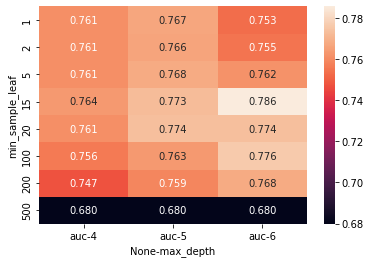

In [41]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

This tell us that maybe there could be another combination of the two parameters that maximizes the `auc` value.

For now, let's try with our final model:

In [42]:
tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

### 5.5 Ensembles and random forest

In the same way we could have a board of experts to review the borrow's requests, we could have a grupo of models, so we can have different results and then have a solution by each one of them voting if the request is aproved (`'ok'`) or rejected (`'default'`).

Every tree model receives a slightly different and smallest set of features randomly choosen from the entire dataset, this way we have a group of trees (forest) each one evaluating a different set of variables.

At the end we take the probability by doing:

$
score = \frac{1}{n} \sum p_{i}
$

Where: 
- $p_{i}$ is the probability of default of the $i-eith$ DecisionTree model
- $n$ is the amount of DecisionTrees in the RandomForest model

#### 5.5.1 Random forest - ensembling decision tree

In [43]:
from sklearn.ensemble import RandomForestClassifier

The number of modles we'll use, is set by the `n_estimators=` parameter:

In [44]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [45]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7868996875832506

Let's iterate for different values of `n_estimators`

In [46]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((n, auc))

In [47]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


Let's plot these results:

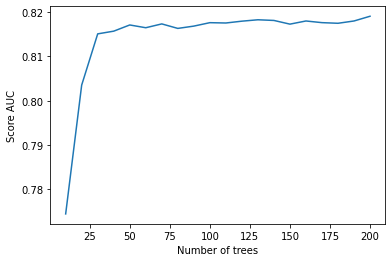

In [48]:
plt.plot(df_scores['n_estimators'], df_scores['auc'])
plt.xlabel('Number of trees')
plt.ylabel('Score AUC')
plt.show()

Approximately around 50 trees, the score gets stable. This means that more trees in our model doesn't make a significatn difference in its performance.

#### 5.5.2 Tuning random forest

We're interested in the same parameters as we did for a DecisionTree model:

In [49]:
scores = []
depths = [5, 10, 15]

for depth in depths:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, n, auc))

In [50]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


Plotting again:

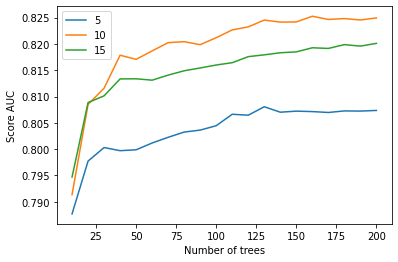

In [51]:
for depth in depths:
    df_subset = df_scores[df_scores['max_depth'] == depth]
    
    plt.plot(df_subset['n_estimators'], df_subset['auc'], label=depth)

plt.xlabel('Number of trees')
plt.ylabel('Score AUC')
plt.legend()
plt.show()


For this case, it seems that a `max_depth=10` is the best choice for this parameter. Let's do the same with `min_samples_leaf`:

In [52]:
scores = []
max_depth = 10
samples_leafs = [1, 3, 5, 10, 50]

for s in samples_leafs:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [53]:
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058


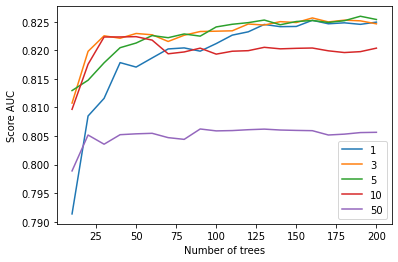

In [54]:
for s in samples_leafs:
    df_subset = df_scores[df_scores['min_samples_leaf'] == s]
    
    plt.plot(df_subset['n_estimators'], df_subset['auc'], label=s)

plt.xlabel('Number of trees')
plt.ylabel('Score AUC')
plt.legend()
plt.show()

We can take a min_samples_leaf=3 for this case. Let's train our final RandomForest model:

In [55]:
max_depth = 10
min_samples_leaf = 3

rf = RandomForestClassifier(n_estimators=n,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [56]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

### 5.6 Gradient boosting and XGBoost

#### 5.6.1 Gradient Boosting vs Random Forest

Gradient boosting is another way to combine multiple DecisionTree models, as we did with RandomForest. In RF we train several independet models and at the end we take an average of their scores.

In boosting we are going to train a model, measure its score and using its errors we train a new one where we'll try to correct these errors and iterate the process as many times as necessary. In this case, each model in our boost will be DecisionTree models.

#### 5.6.2 Installing XGBoost and training the first model

We intalled the package through the console doing:

`pip install xgboost`

In [57]:
import xgboost as xgb

Firstly, we have to wrap our data into a special structure called `DMatrix`, which is optimized to train this kind of models.

In [58]:
features = dv.get_feature_names()

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

Now we can train a model and predict values:

In [59]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthreads': 2,

    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

[15:02:27] WARNING: ../src/learner.cc:576: 
Parameters: { "nthreads" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:02:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [60]:
y_pred = model.predict(dval)

In [61]:
roc_auc_score(y_val, y_pred)

0.8003166549611296

#### 5.6.3 Performance monitoring

We can be monitoring each model's iteration during the training step and measure its scores: 

In [62]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [68]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads': 2,

    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

[15:17:39] WARNING: ../src/learner.cc:576: 
Parameters: { "nthreads" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	train-auc:0.98174	val-auc:0.81878
[30]	train-auc:0.98772	val-auc:0.81788
[35]	train-auc:0.99180	val-auc:0.81510
[40]	train-auc:0.99456	val-auc:0.81387
[45]	train-auc:0.99596	val-auc:0.81462
[50]	train-auc:0.99688	val-auc:0.81128
[55]	train-auc:0.99787	val-auc:0.80874
[60]	train-auc:0.99889	val-auc:0.80801
[65]	train-auc:0.99919	val-auc:0.80751
[70]	train-auc:0.99944	val-auc:0.80732
[75]	train-auc:0.99964	val-auc:0.80692
[80]	train-auc:0.99

What we can see is that around the 110th evaluation, the `train-auc` for the train set becomes 1.0 which might be telling us that the model became __overfitted__.

At the same time, we can see that around the 25th iteration the `val-auc` bacame the maximum.

For a better understanding of this, it would be better to visualize these results.

#### 5.6.4 Parsing xgboost's monitoring output

It is necessary to capture our output, because there is no way to get the `auc` restults printed above.

In [71]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads': 2,

    'seed': 1,
    'verbosity': 0
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

In [74]:
s = output.stdout
line = s.split('\n')[0]

In [75]:
line

'[0]\ttrain-auc:0.86300\tval-auc:0.76818'

In [78]:
num_iter, train_auc, val_auc = line.split('\t')
(num_iter, train_auc, val_auc)

('[0]', 'train-auc:0.86300', 'val-auc:0.76818')

Now we have to treat each one of these three objects:

Let's get rid of the squared brackets for `num_iter`:

In [79]:
int(num_iter.strip('[]'))

0

Treating the `train_auc` and `val_auc`:

In [84]:
float(train_auc.split(':')[1])
float(val_auc.split(':')[1])

0.76818

We can wrap this up into a function that make this process to all the auc data we captured:

In [85]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train_auc = float(train_line.split(':')[1])
        val_auc = float(val_line.split(':')[1])

        results.append((it, train_auc, val_auc))

    df_results = pd.DataFrame(results, columns=['num_iteration', 'train_auc', 'val_auc'])
    
    return df_results

In [87]:
df_scores = parse_xgb_output(output)
df_scores

,num_iteration,train_auc,val_auc
0,0,0.86300,0.76818
1,5,0.92863,0.80606
2,10,0.95002,0.81558
3,15,0.96558,0.81680
4,20,0.97316,0.81775
5,25,0.98174,0.81878
6,30,0.98772,0.81788
7,35,0.99180,0.81510
8,40,0.99456,0.81387
9,45,0.99596,0.81462


Text(0, 0.5, 'AUC')

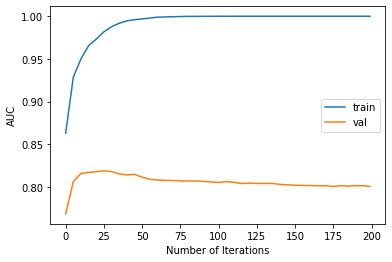

In [89]:
plt.plot(df_scores['num_iteration'], df_scores['train_auc'], label='train')
plt.plot(df_scores['num_iteration'], df_scores['val_auc'], label='val')
plt.legend()
plt.xlabel('Number of Iterations')
plt.ylabel('AUC')

It looks somewhere over 50 iterations the model starts overfiting. Let's take a closer look at `train_auc` values:

Text(0, 0.5, 'AUC')

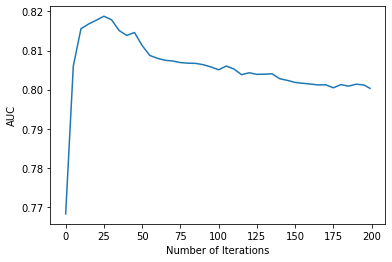

In [91]:
plt.plot(df_scores['num_iteration'], df_scores['val_auc'])
plt.xlabel('Number of Iterations')
plt.ylabel('AUC')

### 5.7 XGBoost parameter tuning